**step 1: importing the dependencies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pickle
from fuzzywuzzy import process

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Loading & Understanding**

In [ ]:

df1 = pd.read_csv('/train.csv')
df2 = pd.read_csv('/autism_screening.csv')


In [ ]:
df1.shape
df2.shape

(704, 21)

In [ ]:
print(df1.head())
print(df2.head())

   ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score        age gender       ethnicity jaundice  \
0         0         1          1  38.172746      f               ?       no   
1         0         0          0  47.750517      m               ?       no   
2         1         1          1   7.380373      m  White-European       no   
3         0         0          0  23.561927      f               ?       no   
4         0         0          0  43.205790      m               ?       no   

  austim  contry_of_res used_app_before     result

In [ ]:
df2.rename(columns={
    'jundice': 'jaundice',  # Fix typo
    'Class/ASD': 'Class/ASD'  # Ensure consistency in all column names
}, inplace=True)

In [ ]:
df2['Class/ASD'] = df2['Class/ASD'].map({'YES': 1, 'NO': 0})


In [ ]:
max_id = df1['ID'].max()
df2['ID'] = range(max_id + 1, max_id + 1 + len(df2))

In [ ]:
combined_df = pd.concat([df1, df2], ignore_index=True)
print(combined_df.head())

   ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score        age gender       ethnicity jaundice  \
0         0         1          1  38.172746      f               ?       no   
1         0         0          0  47.750517      m               ?       no   
2         1         1          1   7.380373      m  White-European       no   
3         0         0          0  23.561927      f               ?       no   
4         0         0          0  43.205790      m               ?       no   

  austim  contry_of_res used_app_before     result

In [ ]:
combined_df.drop_duplicates(inplace=True)

In [ ]:
combined_df.to_csv('combined_dataset.csv', index=False)


In [ ]:
combined_df.tail()


,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
1499,1500,0,1,0,1,1,0,1,1,1,1,25.0,f,White-European,no,no,Russia,no,7.0,18 and more,Self,NaN
1500,1501,1,0,0,0,0,0,0,1,0,1,34.0,m,Hispanic,no,no,Mexico,no,3.0,18 and more,Parent,NaN
1501,1502,1,0,1,1,1,0,1,1,0,1,24.0,f,?,no,no,Russia,no,7.0,18 and more,?,NaN
1502,1503,1,0,0,1,1,0,1,0,1,1,35.0,m,South Asian,no,no,Pakistan,no,6.0,18 and more,Self,NaN
1503,1504,1,0,1,1,1,0,1,1,1,1,26.0,f,White-European,no,no,Cyprus,no,8.0,18 and more,Self,NaN


In [ ]:
# to display all the columns of dataframe
pd.set_option('display.max_columns',None)

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               1504 non-null   int64  
 1   A1_Score         1504 non-null   int64  
 2   A2_Score         1504 non-null   int64  
 3   A3_Score         1504 non-null   int64  
 4   A4_Score         1504 non-null   int64  
 5   A5_Score         1504 non-null   int64  
 6   A6_Score         1504 non-null   int64  
 7   A7_Score         1504 non-null   int64  
 8   A8_Score         1504 non-null   int64  
 9   A9_Score         1504 non-null   int64  
 10  A10_Score        1504 non-null   int64  
 11  age              1502 non-null   float64
 12  gender           1504 non-null   object 
 13  ethnicity        1504 non-null   object 
 14  jaundice         1504 non-null   object 
 15  austim           1504 non-null   object 
 16  contry_of_res    1504 non-null   object 
 17  used_app_befor

In [ ]:
# Check for missing or non-numeric values in the 'age' column
if combined_df['age'].isnull().any():
    print("Warning: 'age' column contains missing values. Filling with default value (e.g., 0).")
    combined_df['age'].fillna(0, inplace=True)

# Convert the 'age' column to integers
try:
    combined_df['age'] = combined_df['age'].astype(int)
    print("Successfully converted 'age' column to integer type.")
except ValueError as e:
    print(f"Error converting 'age' column to integers: {e}")


Successfully converted 'age' column to integer type.


In [ ]:
# to convert age column data type to int
combined_df['age']=combined_df['age'].astype(int)

In [ ]:
combined_df.head(2)

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,1,38,f,?,no,no,Austria,no,6.351166,18 and more,Self,0.0
1,2,0,0,0,0,0,0,0,0,0,0,47,m,?,no,no,India,no,2.255185,18 and more,Self,0.0


In [ ]:
for col in combined_df.columns:
  numeric_data = ["ID","age","result"]
  if col not in numeric_data:
    print(col)
    print(combined_df[col].unique())
    print("="*120)

A1_Score
[1 0]
A2_Score
[0 1]
A3_Score
[1 0]
A4_Score
[0 1]
A5_Score
[1 0]
A6_Score
[0 1]
A7_Score
[1 0]
A8_Score
[0 1]
A9_Score
[1 0]
A10_Score
[1 0]
gender
['f' 'm']
ethnicity
['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
jaundice
['no' 'yes']
austim
['no' 'yes']
contry_of_res
['Austria' 'India' 'United States' 'South Africa' 'Jordan'
 'United Kingdom' 'Brazil' 'New Zealand' 'Canada' 'Kazakhstan'
 'United Arab Emirates' 'Australia' 'Ukraine' 'Iraq' 'France' 'Malaysia'
 'Viet Nam' 'Egypt' 'Netherlands' 'Afghanistan' 'Oman' 'Italy'
 'AmericanSamoa' 'Bahamas' 'Saudi Arabia' 'Ireland' 'Aruba' 'Sri Lanka'
 'Russia' 'Bolivia' 'Azerbaijan' 'Armenia' 'Serbia' 'Ethiopia' 'Sweden'
 'Iceland' 'Hong Kong' 'Angola' 'China' 'Germany' 'Spain' 'Tonga'
 'Pakistan' 'Iran' 'Argentina' 'Japan' 'Mexico' 'Nicaragua' 'Sierra Leone'
 'Czech Republic' 'Niger' 'Romania' 'Cyprus' 'Belgium' 'Burundi'
 'Bangladesh' 'Lebanon' 'Ch

In [ ]:
# drop the age_desc column
combined_df = combined_df.drop(columns=['age_desc'])

In [ ]:
combined_df.shape

(1504, 21)

In [ ]:
#to print all the columns name
combined_df.columns

Index(['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
       'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'result', 'relation', 'Class/ASD'],
      dtype='object')

In [ ]:
# to print particular column values
combined_df[['ID']]

,ID
0,1
1,2
2,3
3,4
4,5
...,...
1499,1500
1500,1501
1501,1502
1502,1503


In [ ]:
combined_df[['used_app_before']]


,used_app_before
0,no
1,no
2,no
3,no
4,no
...,...
1499,no
1500,no
1501,no
1502,no


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('used_app_before').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

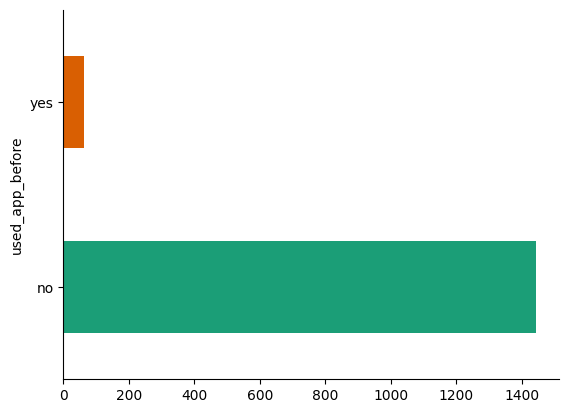

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('used_app_before').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
combined_df = combined_df.drop(columns=['used_app_before'])

In [ ]:
combined_df.shape

(1504, 20)

In [ ]:
combined_df[['contry_of_res']]

,contry_of_res
0,Austria
1,India
2,United States
3,United States
4,South Africa
...,...
1499,Russia
1500,Mexico
1501,Russia
1502,Pakistan


No charts were generated by quickchart


In [ ]:
# for change the information (like model ask contry name but user enter state name ) so we can change by using following methods
# define the mapping dictionary for country names
mapping={
    "Delhi":"India",
    "Telangana":"India",
    "Tamil Nadu":"India",
}
# replace value in the country column
combined_df['contry_of_res']=combined_df['contry_of_res'].replace(mapping)

In [ ]:
# when we use [[]] we can use additional features like we can represent data intable form and chart form
combined_df[['contry_of_res']]


,contry_of_res
0,Austria
1,India
2,United States
3,United States
4,South Africa
...,...
1499,Russia
1500,Mexico
1501,Russia
1502,Pakistan


In [ ]:
# for showing only unique values
combined_df['contry_of_res'].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Viet Nam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'AmericanSamoa', 'Bahamas', 'Saudi Arabia',
       'Ireland', 'Aruba', 'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan',
       'Armenia', 'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'Hong Kong',
       'Angola', 'China', 'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran',
       'Argentina', 'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone',
       'Czech Republic', 'Niger', 'Romania', 'Cyprus', 'Belgium',
       'Burundi', 'Bangladesh', 'Lebanon', 'Chile', 'Philippines',
       'Costa Rica', 'Uruguay', 'Portugal', 'Ecuador', 'Finland',
       'Turkey', 'Nepal', 'Indonesia'], dtype=object)

In [ ]:
# target class distribution
combined_df["Class/ASD"].value_counts()

,count
Class/ASD,
0.0,639
1.0,161


**Insights**
- 1. missing values in thnicity & relation
- 2. age_desc column has only 1 unique value. so it is removed as it is not important for prediction
- 3. fixed country names
- 4. identified class imbalance in the target class

**EDA(Exploratory Data Analysis)**

In [ ]:
# to know additional value about dataset
combined_df.describe()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,800.000000
mean,752.500000,0.635638,0.494016,0.453457,0.452793,0.443484,0.294548,0.406915,0.574468,0.414894,0.597074,28.736037,6.823034,0.201250
std,434.311716,0.481411,0.500130,0.497995,0.497932,0.496961,0.455991,0.491422,0.494588,0.492868,0.490649,16.452965,4.307649,0.401185
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.137748,0.000000
25%,376.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,3.650181,0.000000
50%,752.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,26.000000,6.146893,0.000000
75%,1128.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,10.000000,0.000000
max,1504.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,383.000000,15.853126,1.000000


In [ ]:
combined_df= combined_df.drop(columns=['ID'])

In [ ]:
combined_df.shape

(1504, 19)

In [ ]:
combined_df.describe()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,800.000000
mean,752.500000,0.635638,0.494016,0.453457,0.452793,0.443484,0.294548,0.406915,0.574468,0.414894,0.597074,28.736037,6.823034,0.201250
std,434.311716,0.481411,0.500130,0.497995,0.497932,0.496961,0.455991,0.491422,0.494588,0.492868,0.490649,16.452965,4.307649,0.401185
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.137748,0.000000
25%,376.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,3.650181,0.000000
50%,752.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,26.000000,6.146893,0.000000
75%,1128.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,10.000000,0.000000
max,1504.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,383.000000,15.853126,1.000000


**Univariate Analysis**

First we work on Numerical Columns:
- age
- result

In [ ]:
# set the desired theme
sns.set_theme(style="darkgrid")

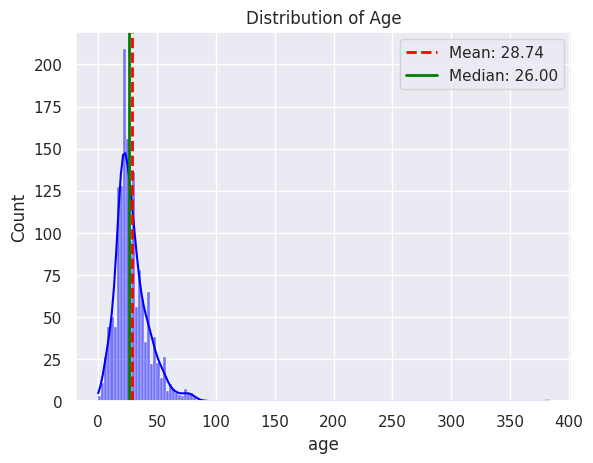

In [ ]:
# Histogram for "age"
sns.histplot(combined_df['age'],kde=True,color="blue")
plt.title("Distribution of Age")

# Calculate mean and median
mean_age = combined_df['age'].mean()
median_age = combined_df['age'].median()

# Add mean and median values to the plot
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
plt.axvline(median_age, color='green', linestyle='-', linewidth=2, label=f'Median: {median_age:.2f}')

plt.legend()
plt.show()

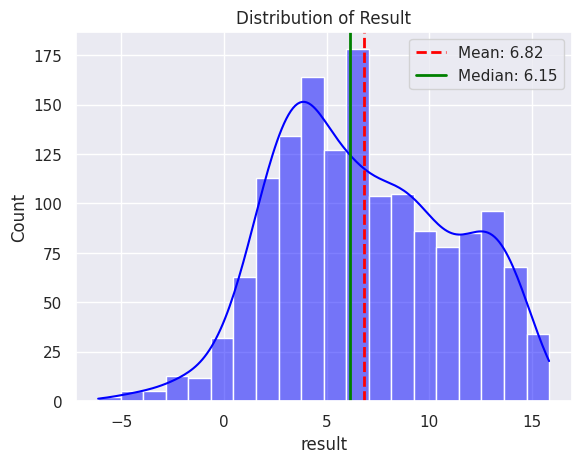

In [ ]:
# Histogram for "result"
sns.histplot(combined_df['result'],kde=True,color="blue")
plt.title("Distribution of Result")

# Calculate mean and median
mean_result = combined_df['result'].mean()
median_result = combined_df['result'].median()

# Add mean and median values to the plot
plt.axvline(mean_result, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_result:.2f}')
plt.axvline(median_result, color='green', linestyle='-', linewidth=2, label=f'Median: {median_result:.2f}')

plt.legend()
plt.show()

**Box plots for identifying outliers in the numerical columns**

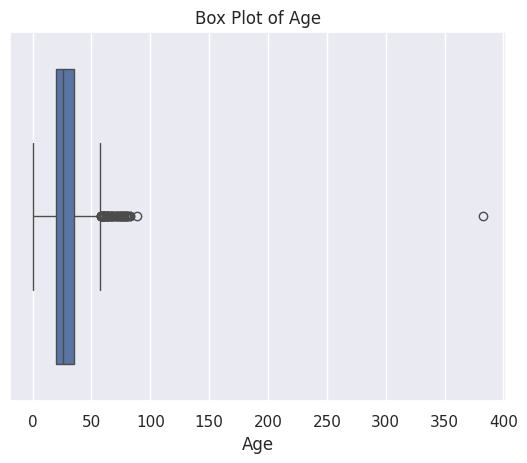

In [ ]:
# Box plot
sns.boxplot(x=combined_df['age'])
plt.title("Box Plot of Age")
plt.xlabel("Age")
plt.show()

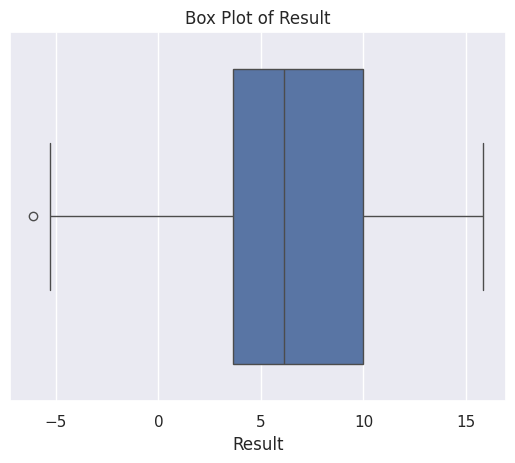

In [ ]:
# Box plot
sns.boxplot(x=combined_df['result'])
plt.title("Box Plot of Result")
plt.xlabel("Result")
plt.show()

In [ ]:
# Count the outliers using IQR method
Q1 = combined_df['age'].quantile(0.25)
Q3 = combined_df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
age_outliers = combined_df[(combined_df['age'] < lower_bound) | (combined_df['age'] > upper_bound)]

In [ ]:
age_outliers

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,result,relation,Class/ASD
19,1,1,1,1,1,1,1,1,1,1,72,m,White-European,no,yes,United States,12.286905,Self,1.0
31,0,1,0,0,0,0,0,1,0,0,74,f,Asian,no,no,Jordan,2.412387,Self,0.0
33,1,1,1,1,1,1,1,0,1,1,67,m,White-European,yes,no,New Zealand,11.647281,Self,0.0
41,1,1,1,1,1,0,1,1,1,1,74,m,White-European,no,no,United Kingdom,7.387992,Self,0.0
92,0,1,1,1,1,1,0,1,1,1,75,m,Latino,no,yes,United States,6.699799,Self,0.0
93,0,0,0,0,0,0,0,0,0,0,79,m,?,no,no,India,7.813125,Self,0.0
114,1,1,1,0,0,0,1,1,1,1,61,m,White-European,yes,yes,United States,12.246844,Self,0.0
124,1,1,0,1,1,0,1,1,0,1,58,f,Black,no,yes,Canada,12.423455,Self,1.0
161,1,1,1,1,1,1,1,1,1,1,79,f,White-European,yes,yes,United States,10.482143,Self,0.0
231,1,1,1,1,1,1,1,1,1,1,69,f,White-European,no,no,United States,2.459004,Self,1.0


In [ ]:
len(age_outliers)

57

**Univariate analysis of Categorical columns**

In [ ]:
combined_df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'result',
       'relation', 'Class/ASD'],
      dtype='object')

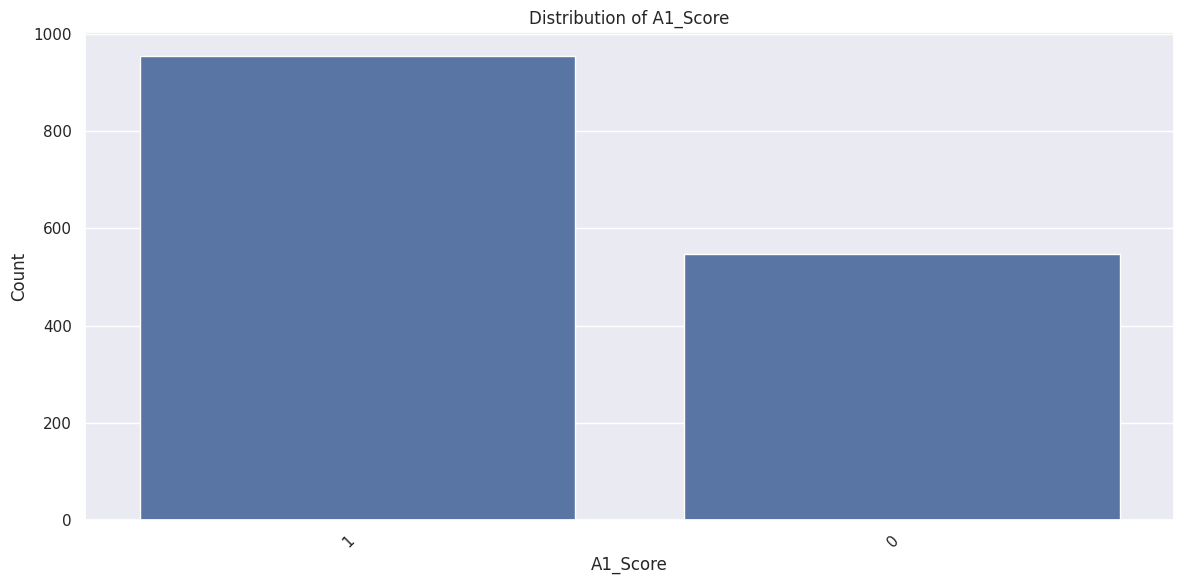

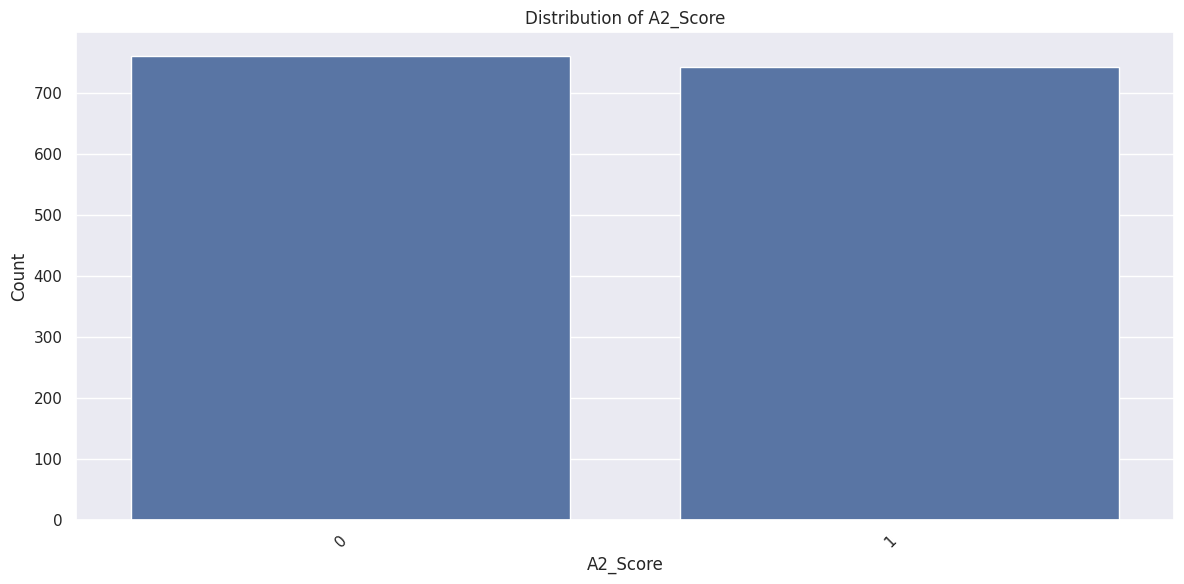

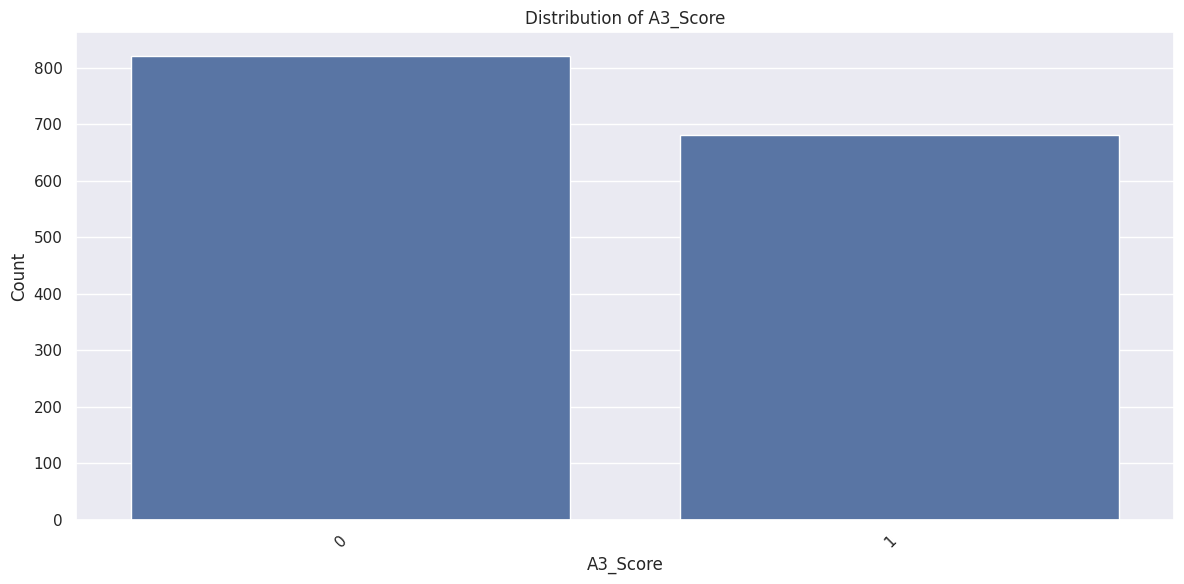

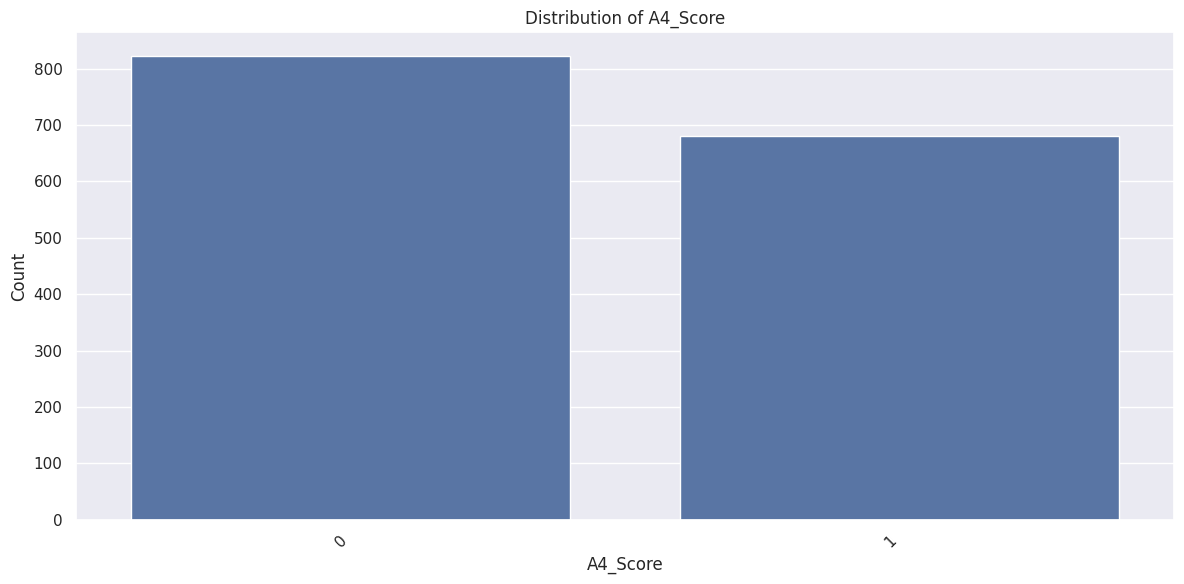

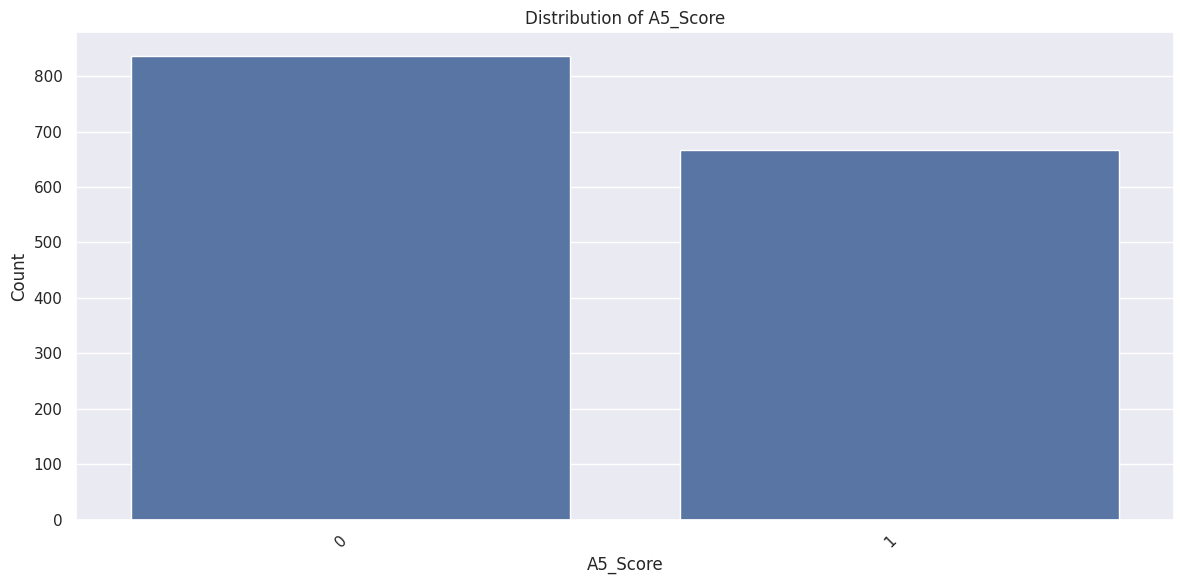

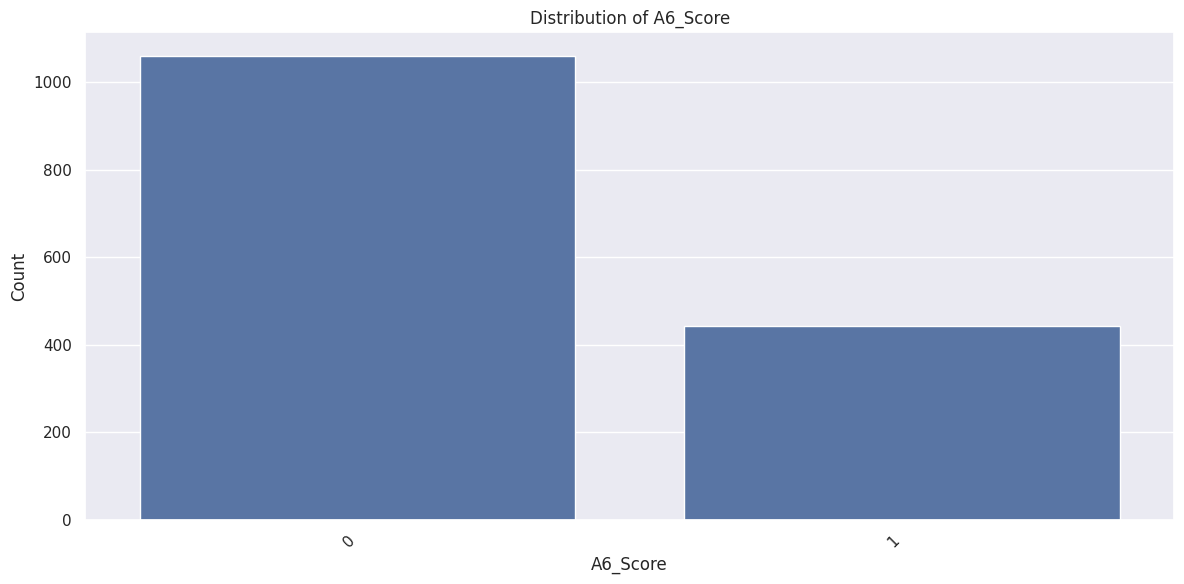

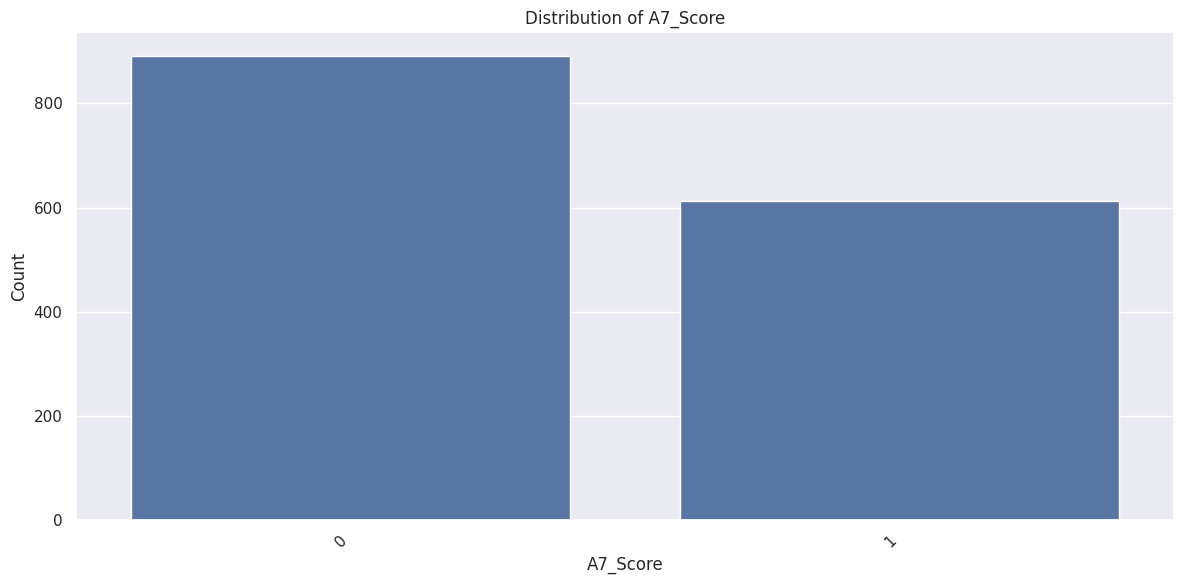

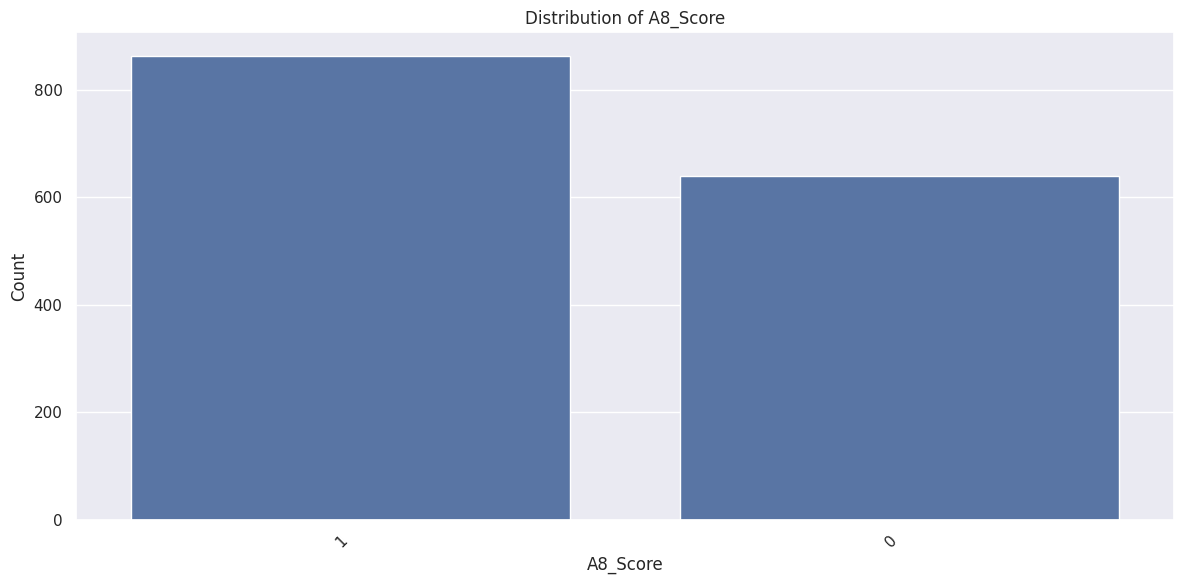

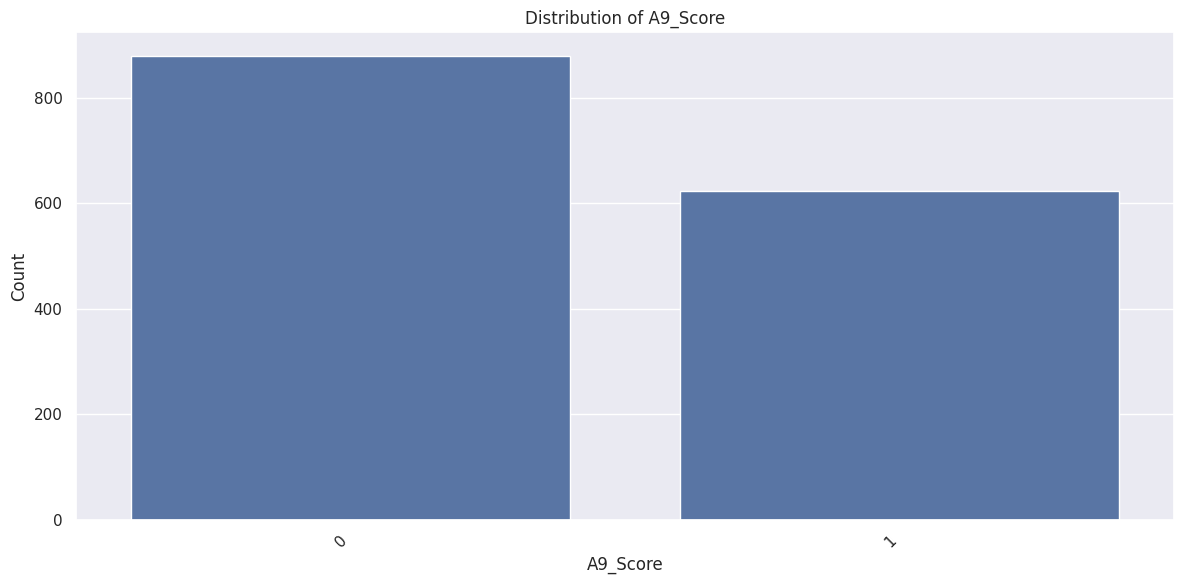

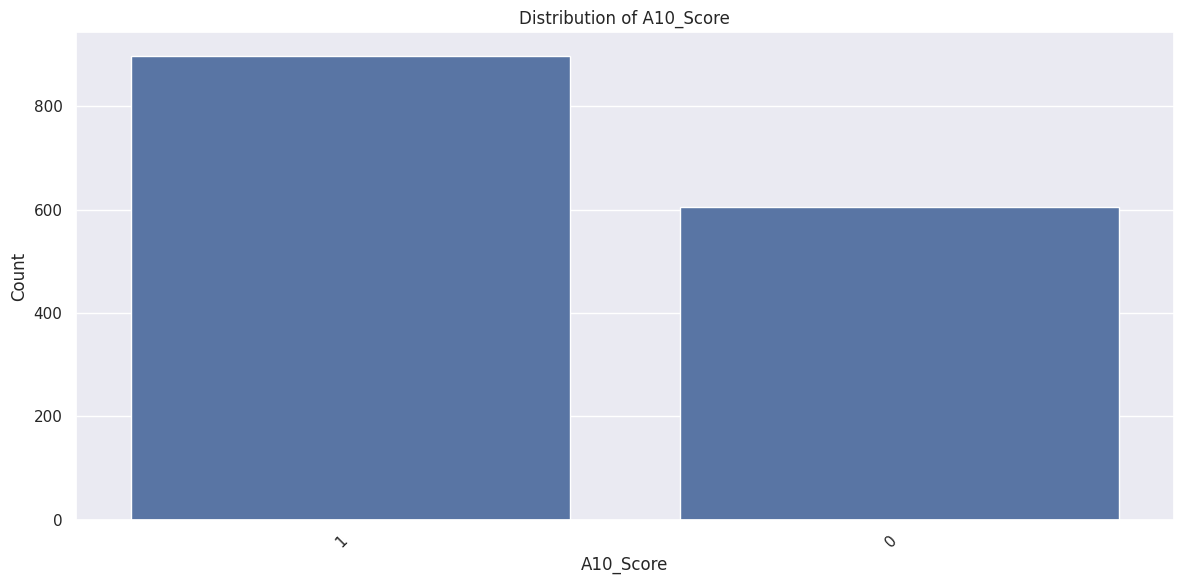

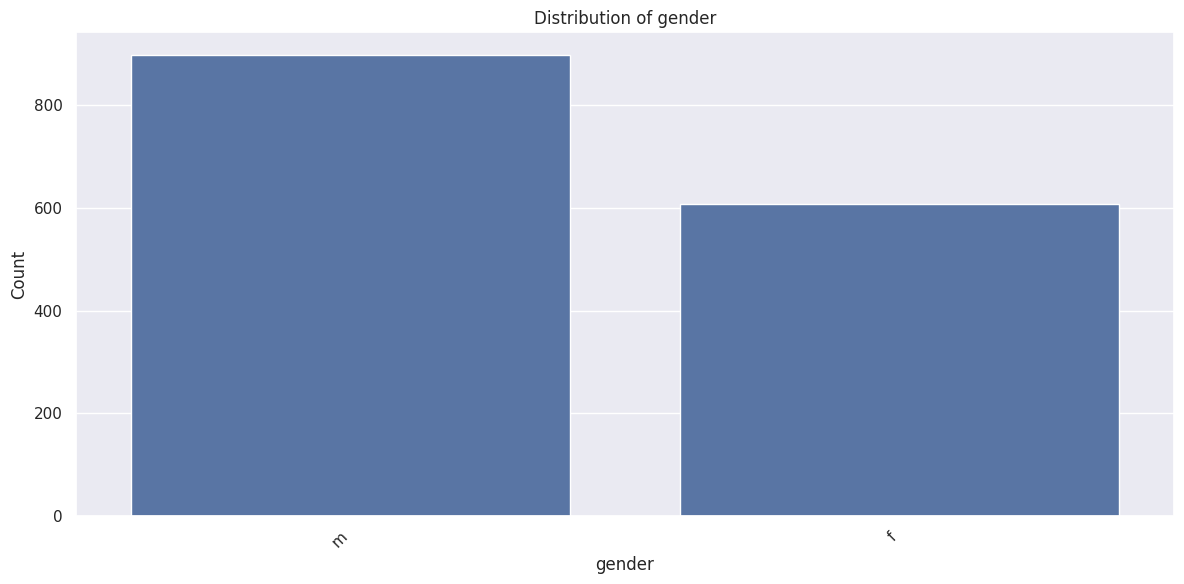

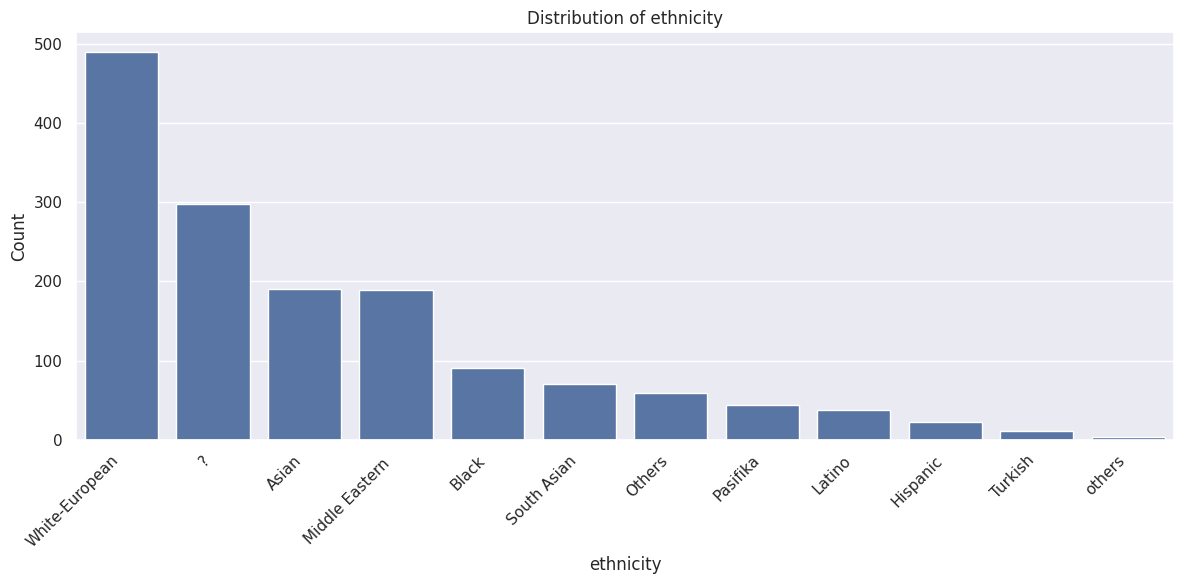

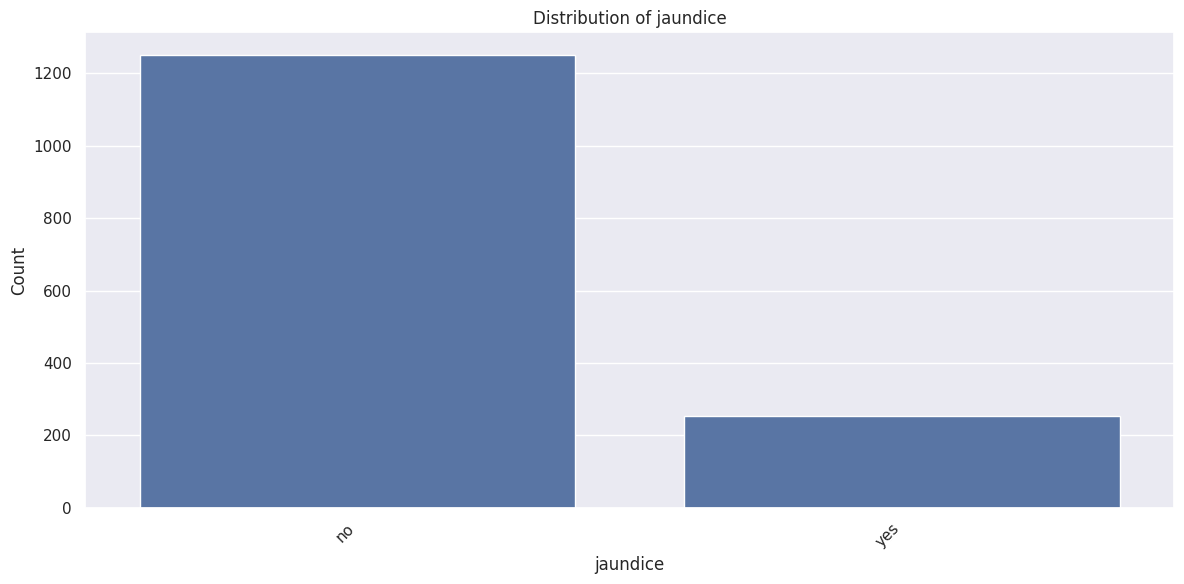

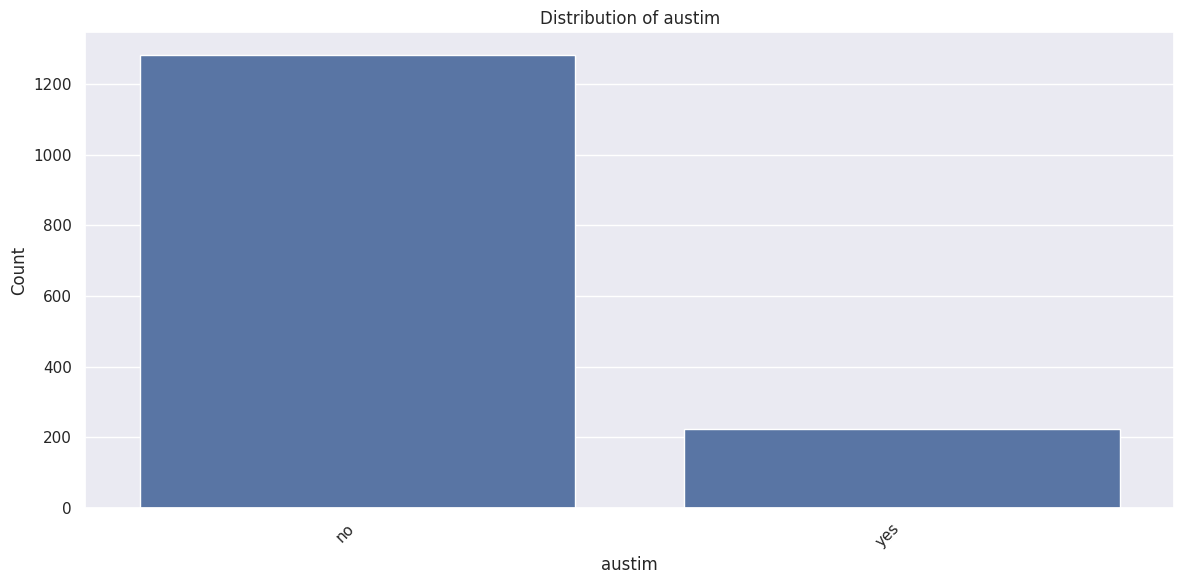

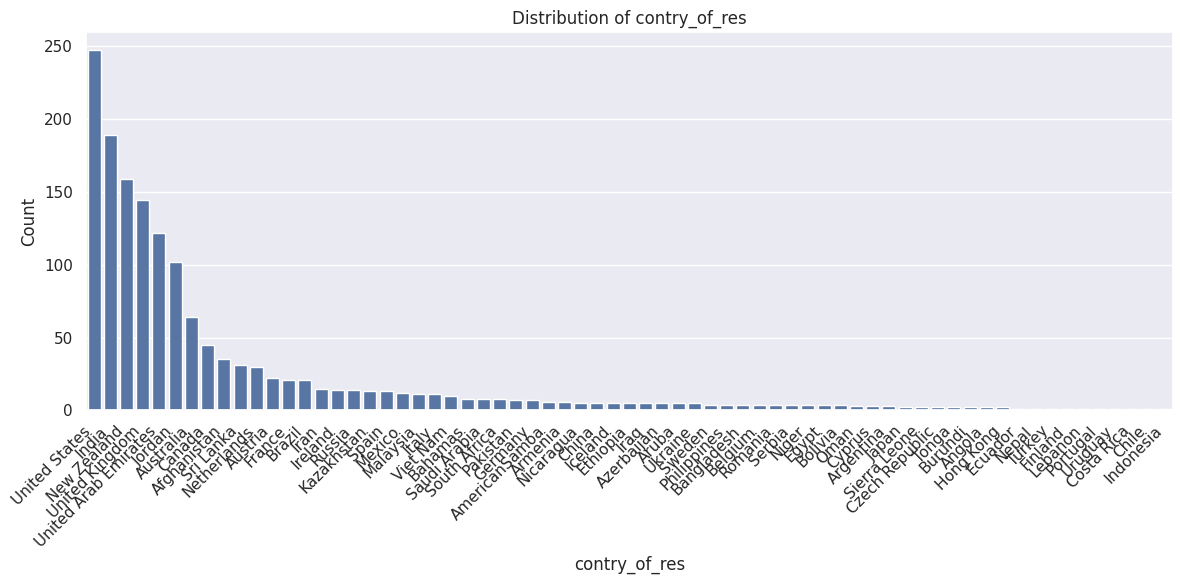

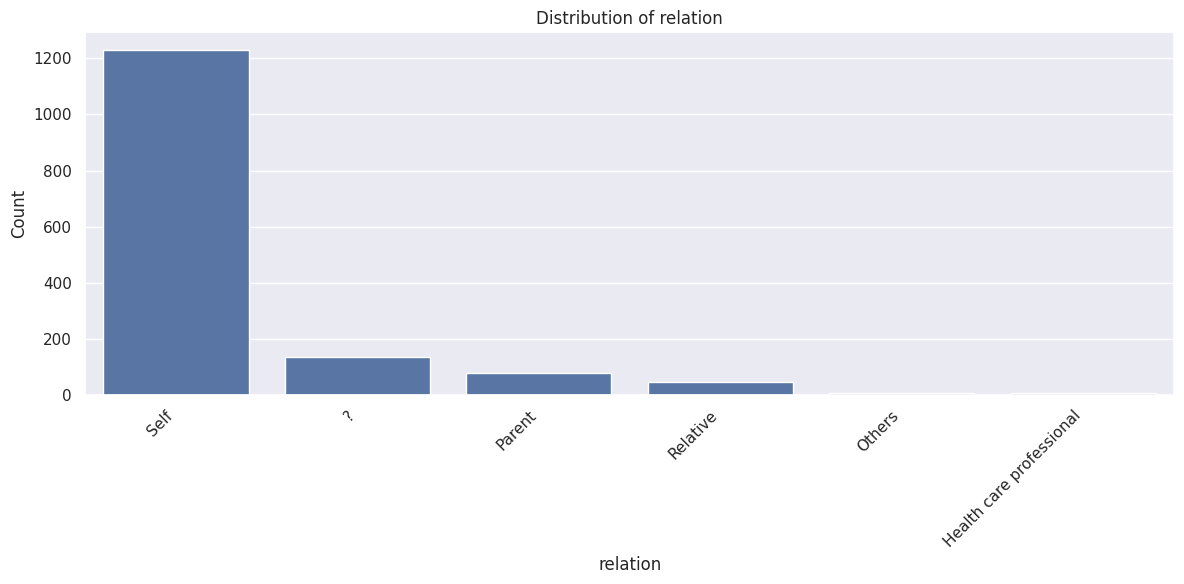

In [ ]:
categorical_columns=['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'relation']

for col in categorical_columns:
    plt.figure(figsize=(12, 6))  # Adjust figure size for better clarity
    sns.countplot(x=combined_df[col], order=combined_df[col].value_counts().index)  # Sort by frequency
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them for clarity
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

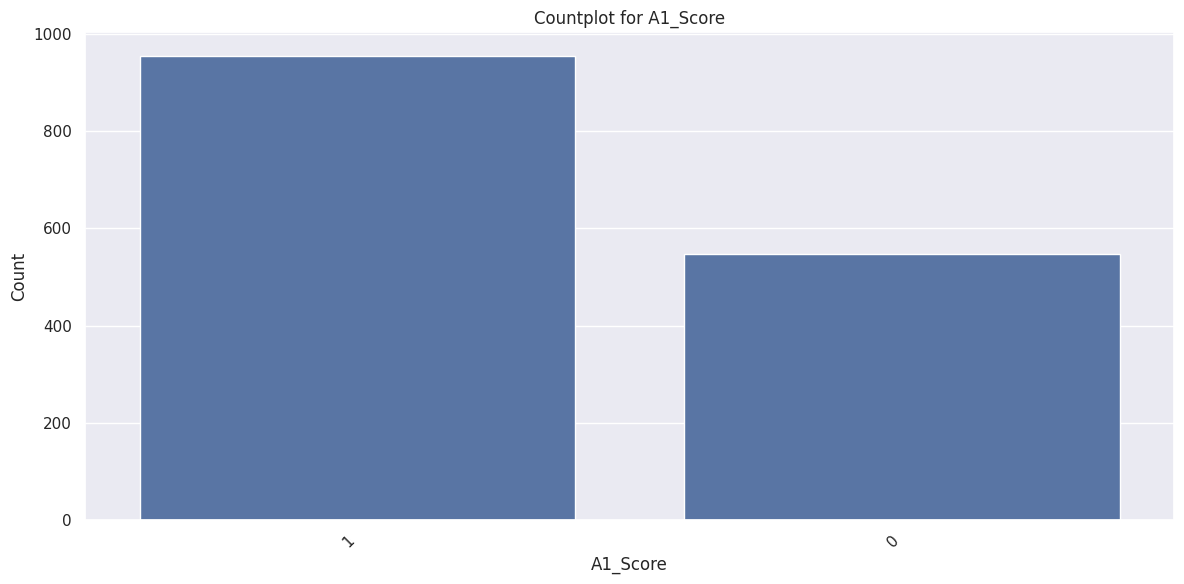

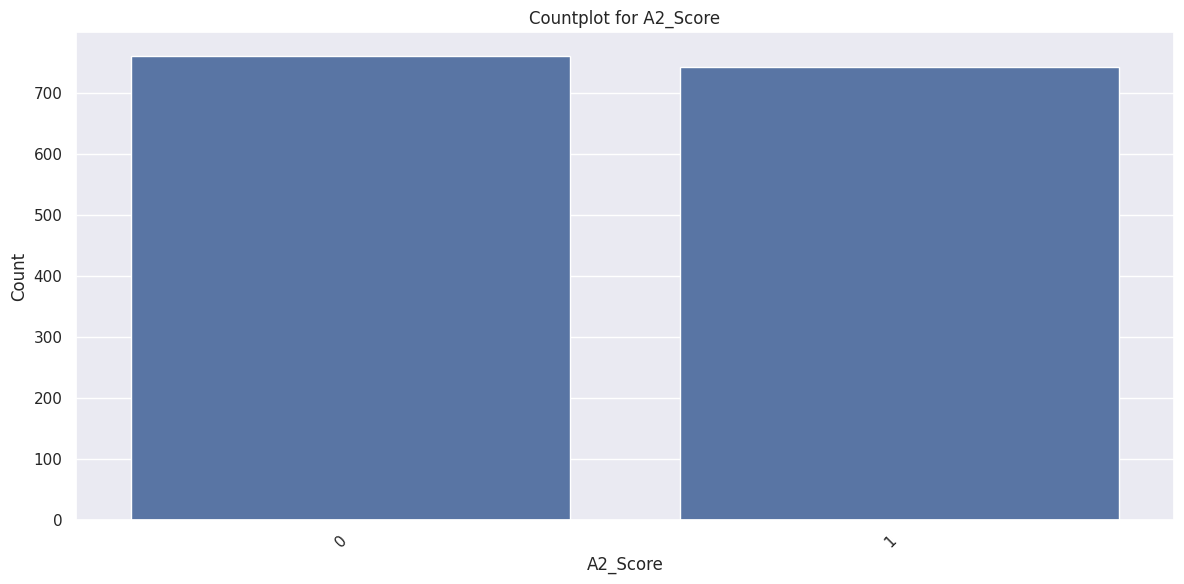

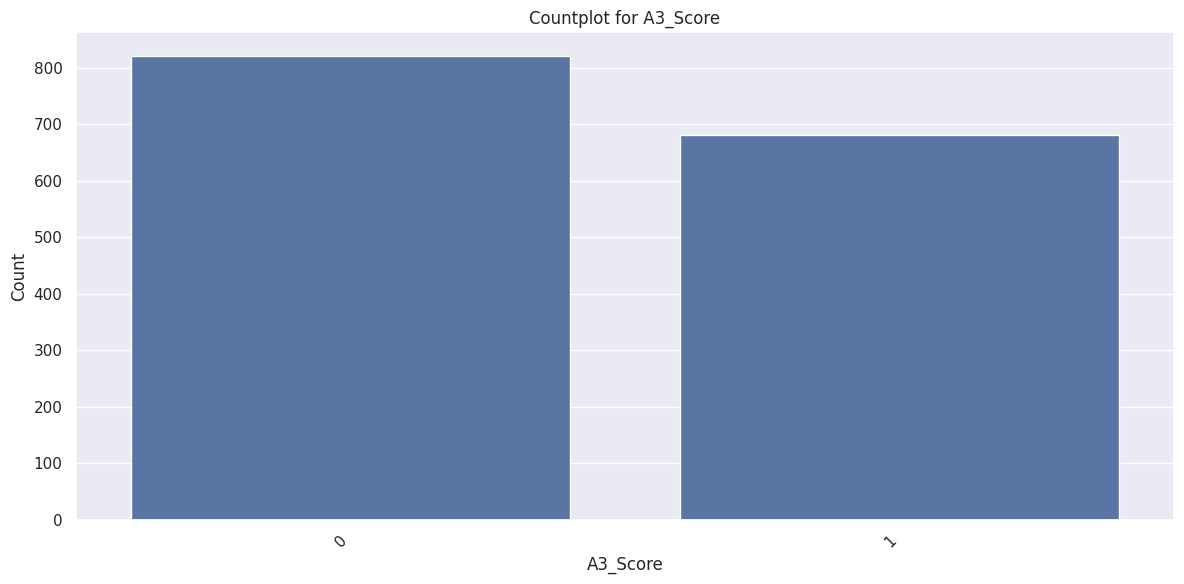

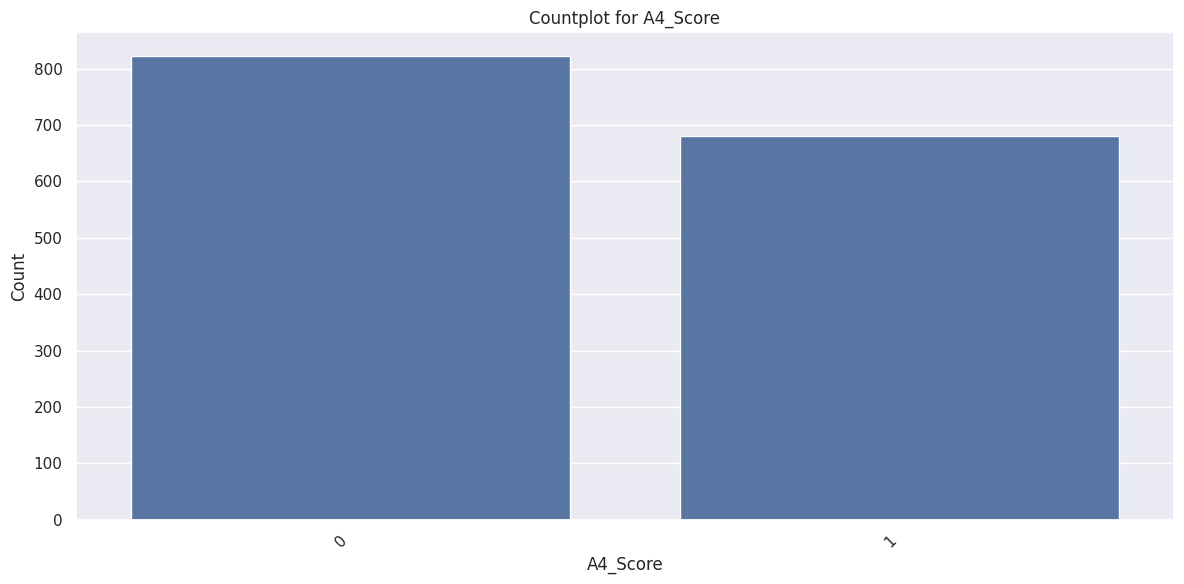

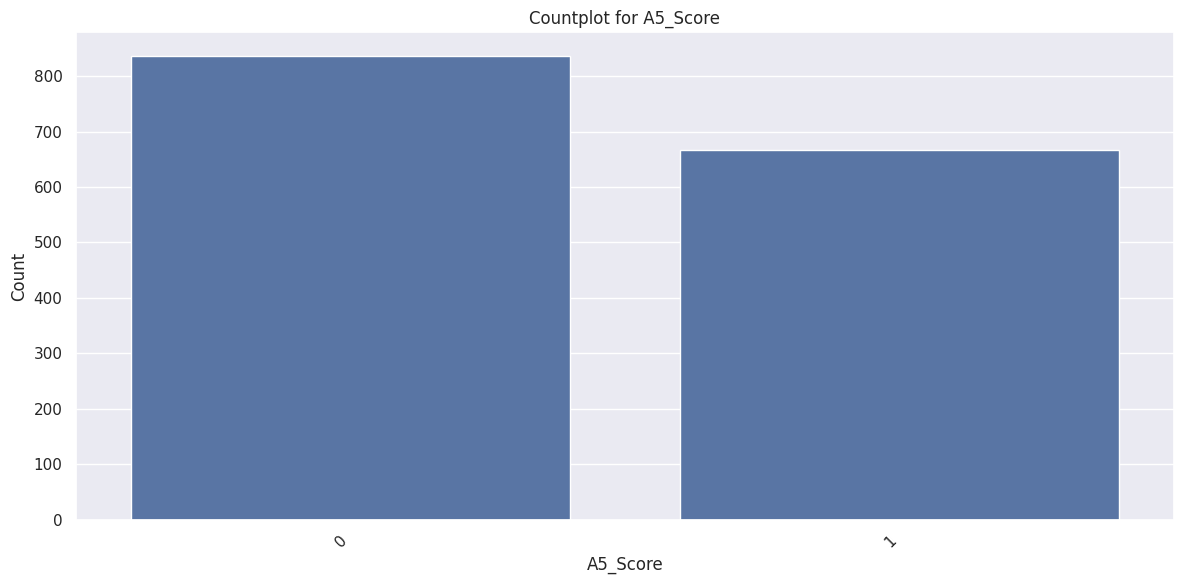

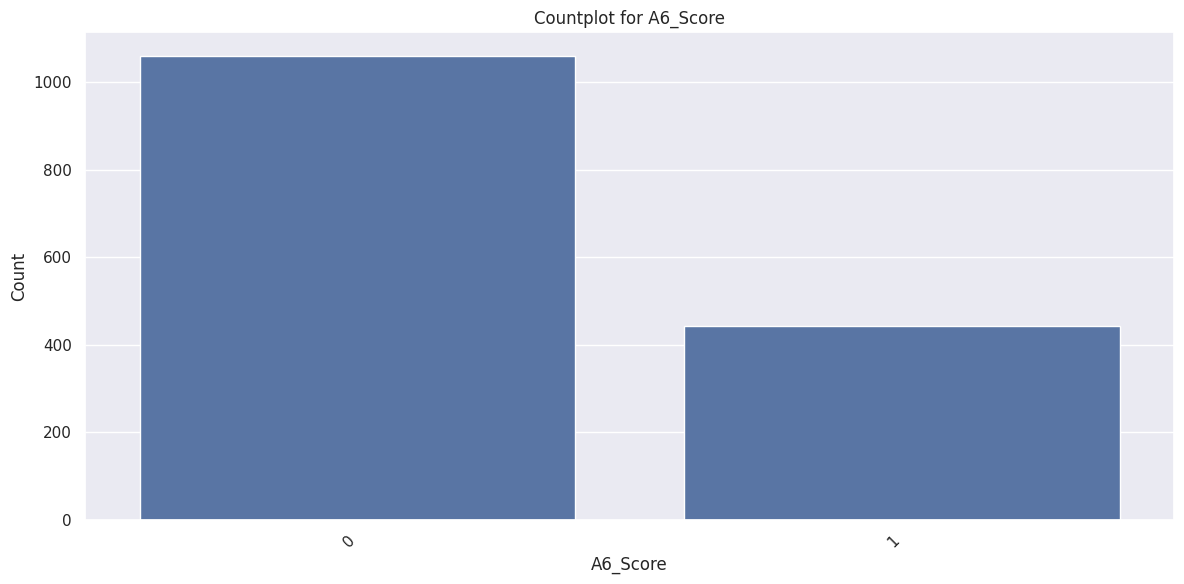

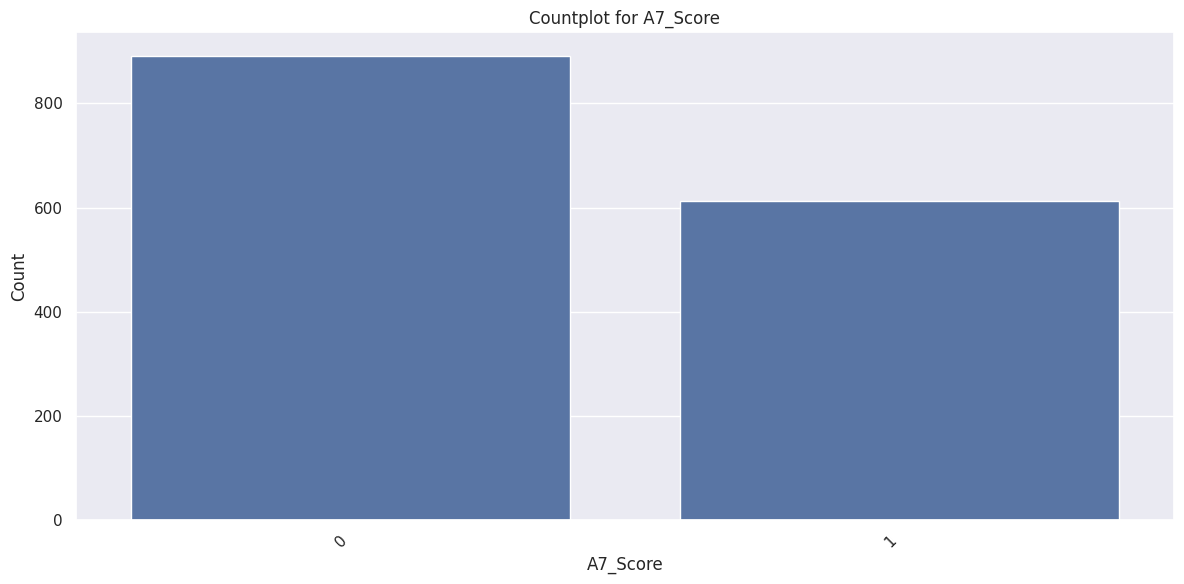

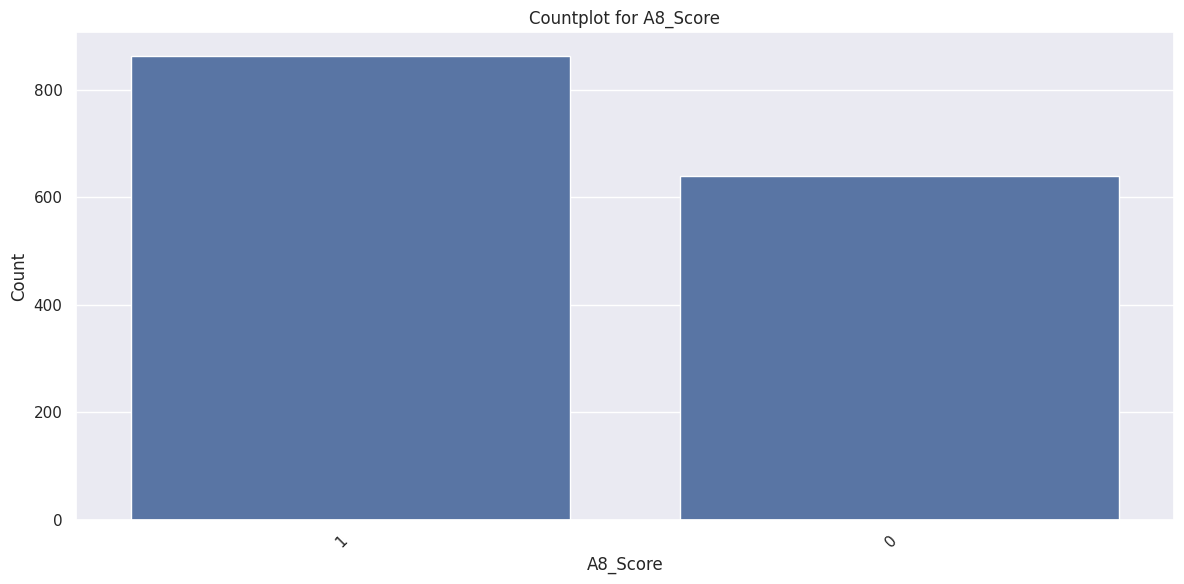

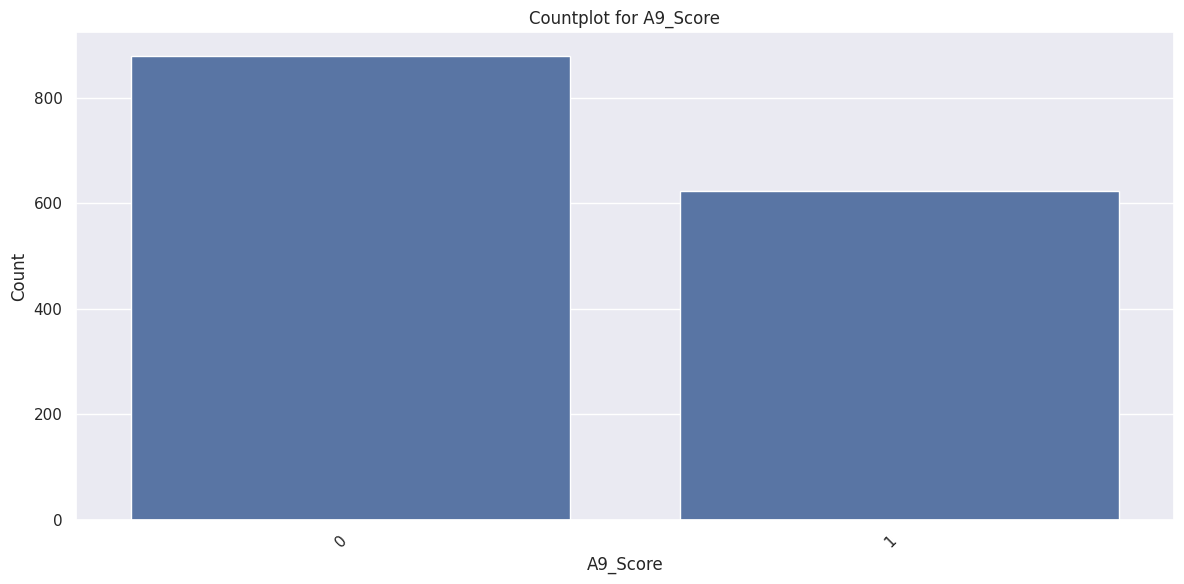

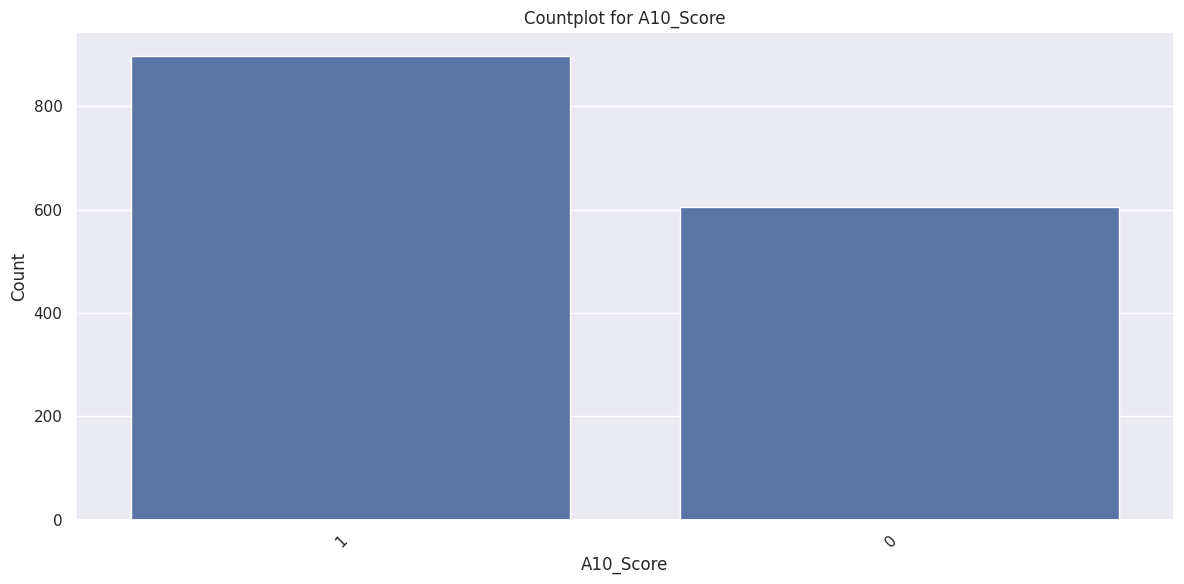

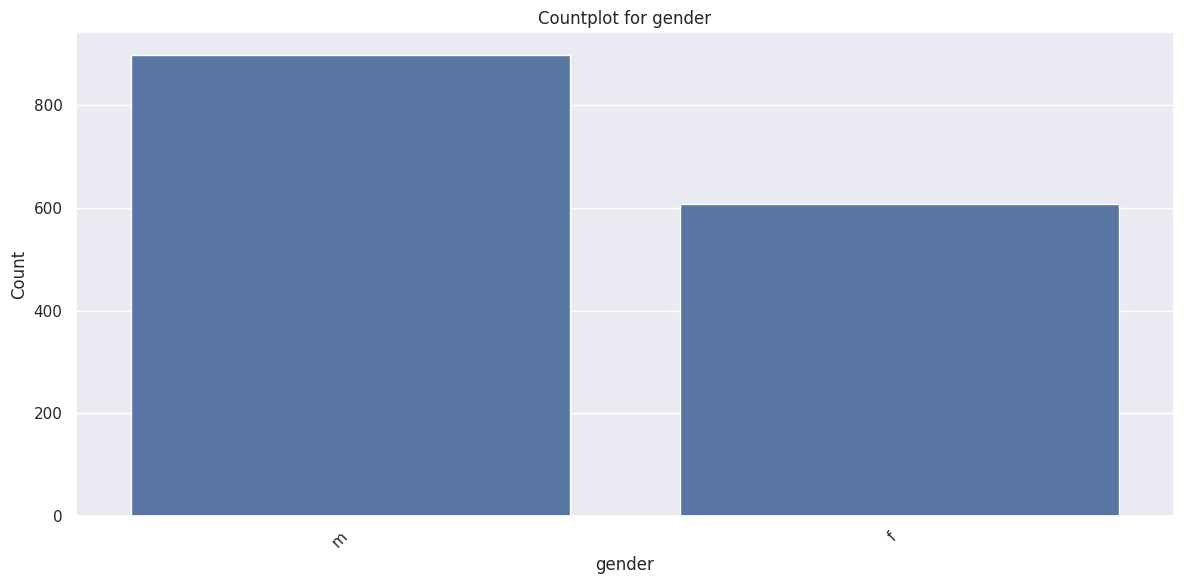

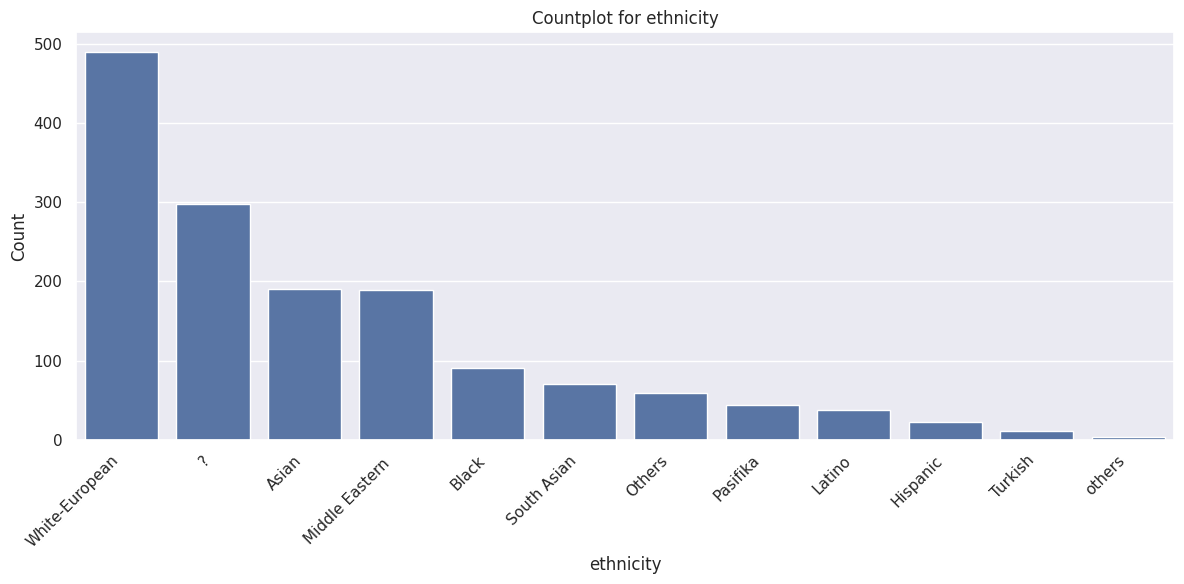

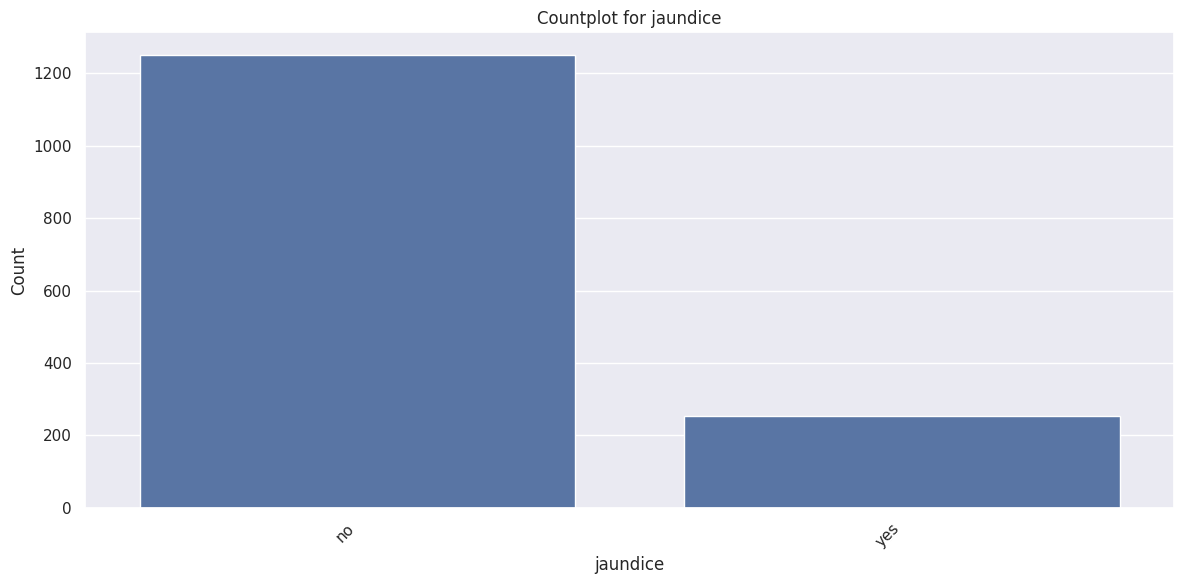

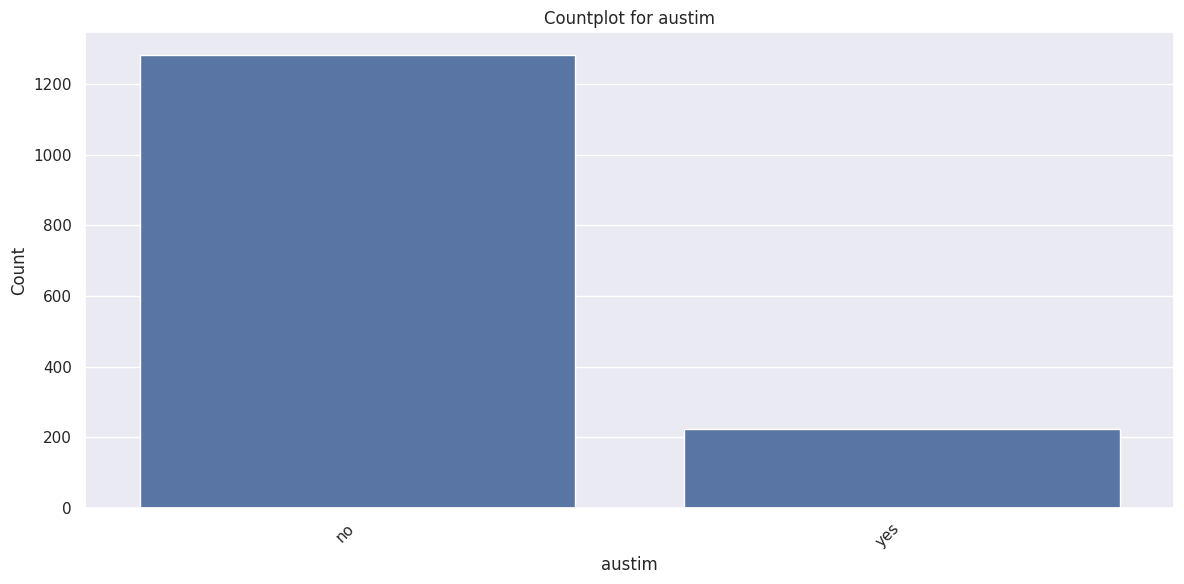

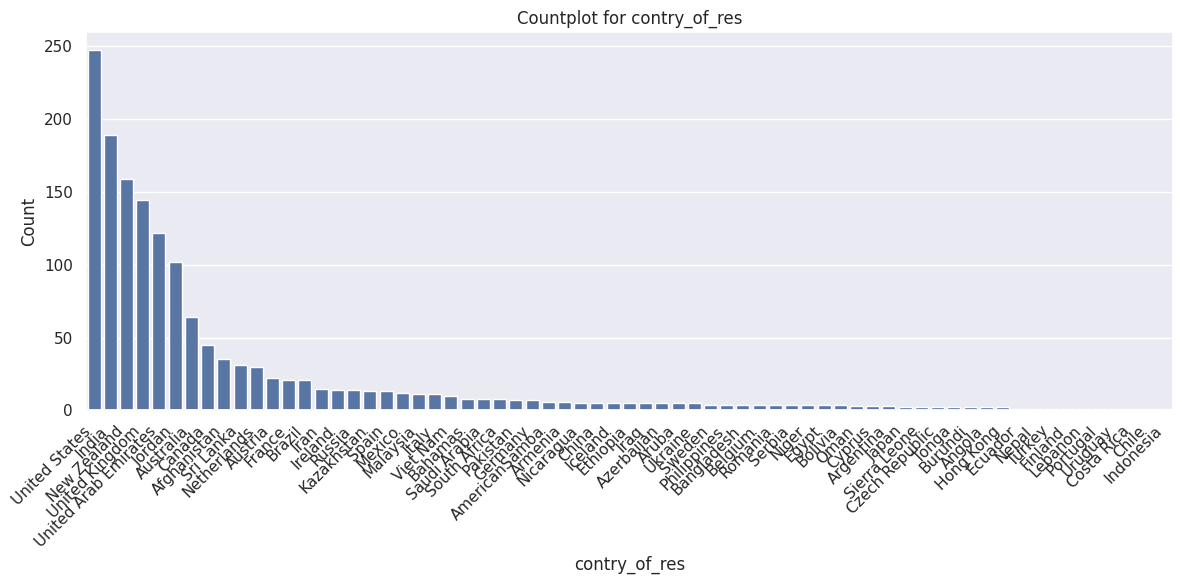

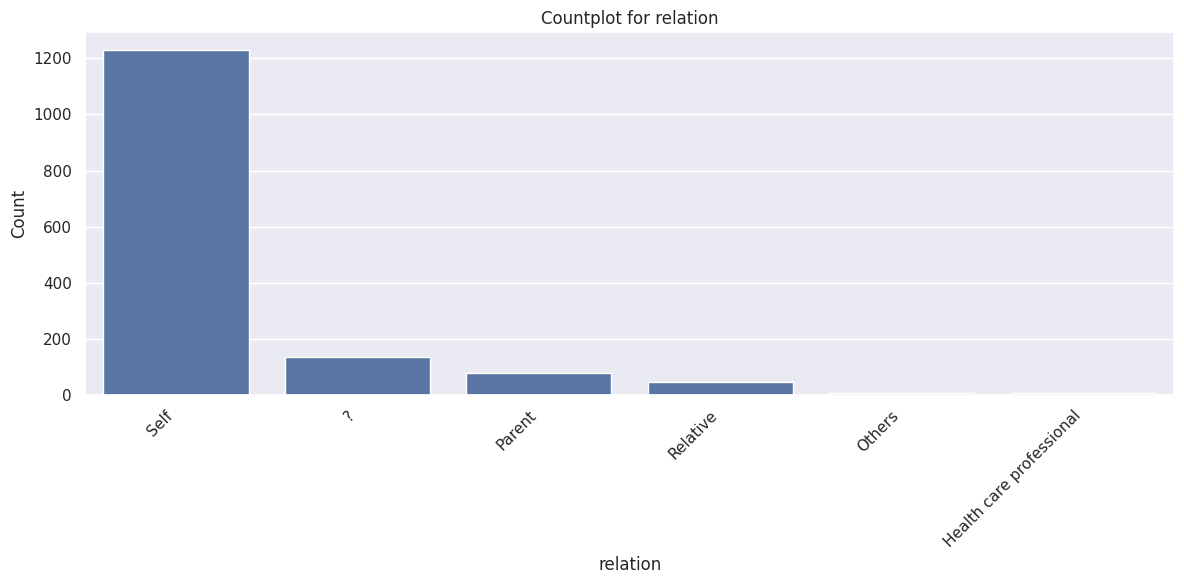

In [ ]:
# countplot for target column (Class/ASD)
for col in categorical_columns:
    plt.figure(figsize=(12, 6))  # Adjust figure size
    sns.countplot(x=combined_df[col], order=combined_df[col].value_counts().index)  # Sort by frequency
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Countplot for {col}")
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

In [ ]:
combined_df["Class/ASD"].value_counts()

,count
Class/ASD,
0.0,639
1.0,161


**handling missing values in ethenicity and relation columns**

In [ ]:
combined_df['ethnicity'].unique()

array(['?', 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
       'Others', 'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino',
       'others'], dtype=object)

In [ ]:
combined_df["ethnicity"]=combined_df["ethnicity"].replace({"?":"Others","others":"Others"})

In [ ]:
combined_df['relation'].unique()

array(['Self', 'Relative', 'Parent', '?', 'Others',
       'Health care professional'], dtype=object)

In [ ]:
combined_df["relation"]=combined_df["relation"].replace({"?":"Others","others":"Others","Health care professional":"Others","Parent":"Others","Relative":"Others"})

In [ ]:
combined_df['relation'].unique()

array(['Self', 'Others'], dtype=object)

**Label Encoding**

In [ ]:
# identify columns with "object" data type
object_columns = combined_df.select_dtypes(include=['object']).columns

In [ ]:
print(object_columns)

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'relation'],
      dtype='object')


In [ ]:
# initialize a dictionary to store the encoders
encoders={}

# apply label encoding and store the encoders
for col in object_columns:
  encoder=LabelEncoder()
  combined_df[col]=encoder.fit_transform(combined_df[col])
  encoders[col]=encoder                   # saving the encoder for this column

  # save the encoders as a pickle file
  with open("encoder.pkl","wb") as f:
    pickle.dump(encoder,f)

In [ ]:
encoders

{'gender': LabelEncoder(),
 'ethnicity': LabelEncoder(),
 'jaundice': LabelEncoder(),
 'austim': LabelEncoder(),
 'contry_of_res': LabelEncoder(),
 'relation': LabelEncoder()}

In [ ]:
combined_df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,0,5,0,0,7,6.351166,1,0.0
1,0,0,0,0,0,0,0,0,0,0,47,1,5,0,0,29,2.255185,1,0.0
2,1,1,1,1,1,1,1,1,1,1,7,1,9,0,1,64,14.851484,1,1.0
3,0,0,0,0,0,0,0,0,0,0,23,0,5,0,0,64,2.276617,1,0.0
4,0,0,0,0,0,0,0,0,0,0,43,1,5,0,0,55,-4.777286,1,0.0


**Bivariate Analysis**

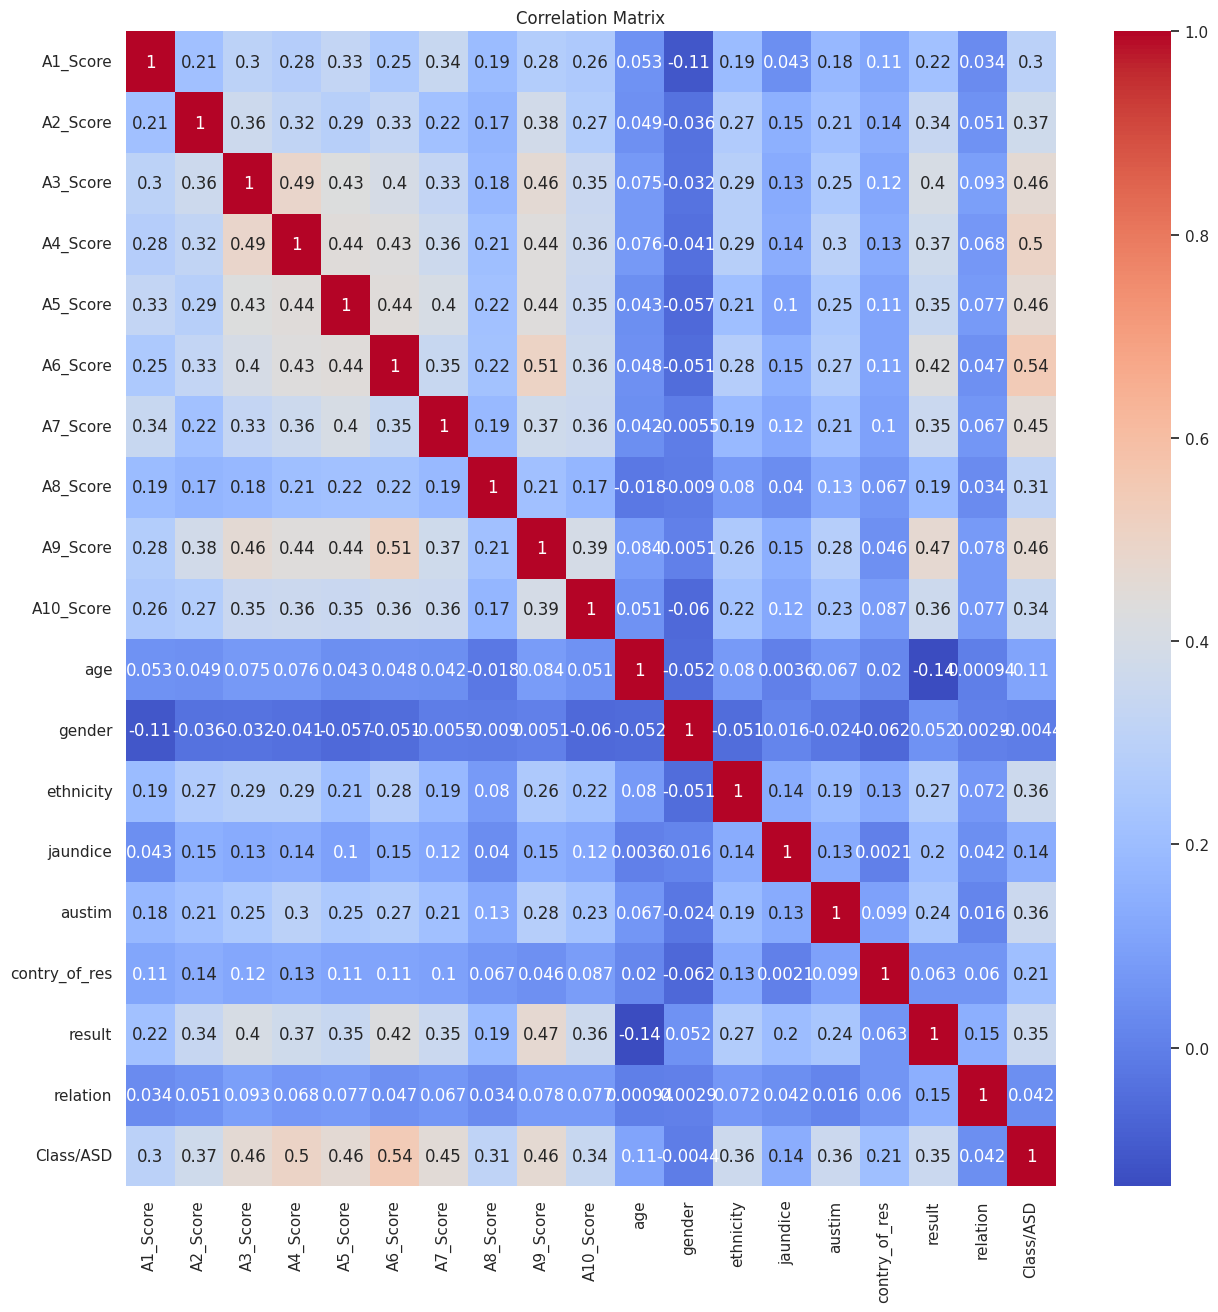

In [ ]:
# Correlation matrics
plt.figure(figsize=(15,15))
sns.heatmap(combined_df.corr(),annot=True,cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

**Insights from EDA**
- There are few outliers in the numerical columns(age,results)
- There is a class imbalance in the target column
- There is a class imbalance in the categorical features
- We don't have any highly correlated column
- performded label encoding and saved the encoders

**4. Data Preprocessing**

Handling the outliers

In [ ]:
# function to replace the outliers with median
def replace_outliers_with_median(combined_df,column):
  Q1 = combined_df[column].quantile(0.25)
  Q3 = combined_df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  median_value = combined_df[column].median()

  combined_df[column] = combined_df[column].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
  return combined_df

In [ ]:
# replace outliers in the "age" column
combined_df = replace_outliers_with_median(combined_df,"age")
# replace outliers in the "result" column
combined_df = replace_outliers_with_median(combined_df,"result")

In [ ]:
combined_df.shape

(1504, 19)

**Train Test Split**

In [ ]:
x=combined_df.drop(columns=["Class/ASD"])
y=combined_df["Class/ASD"]

In [ ]:
print(x)

      A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0            1         0         1         0         1         0         1   
1            0         0         0         0         0         0         0   
2            1         1         1         1         1         1         1   
3            0         0         0         0         0         0         0   
4            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
1499         0         1         0         1         1         0         1   
1500         1         0         0         0         0         0         0   
1501         1         0         1         1         1         0         1   
1502         1         0         0         1         1         0         1   
1503         1         0         1         1         1         0         1   

      A8_Score  A9_Score  A10_Score   age  gender  ethnicity  j

In [ ]:
print(y)

0       0.0
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
1499    NaN
1500    NaN
1501    NaN
1502    NaN
1503    NaN
Name: Class/ASD, Length: 1504, dtype: float64


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=32)

In [ ]:
print(y_train.shape)
print(y_test.shape)

(1203,)
(301,)


In [ ]:
y_train.value_counts()

,count
Class/ASD,
0.0,519
1.0,129


**SMOTE(synthetic Minority Oversampling technique**

In [ ]:
smote=SMOTE(random_state=32)

In [ ]:
nan_indices = y_train[y_train.isnull()].index
y_train = y_train.dropna()
x_train = x_train.drop(index=nan_indices)

In [ ]:
x_train_smote,y_train_smote=smote.fit_resample(x_train,y_train)

In [ ]:
print(y_train_smote.shape)

(1038,)


In [ ]:
print(y_train_smote.value_counts())

Class/ASD
0.0    519
1.0    519
Name: count, dtype: int64


**Model Training**

In [ ]:
# Dictionary of classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=32),
    "Random Forest": RandomForestClassifier(random_state=32),
    "XGBoost": XGBClassifier(random_state=32)
}


In [ ]:
# dictionary to store the cross validation results
cv_results = {}

#perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name}...")
  scores = cross_val_score(model, x_train_smote, y_train_smote, cv=5, scoring='accuracy')
  cv_results[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {scores.mean():.4f}")
  print("-"*50)

Training Decision Tree...
Decision Tree cross-validation accuracy: 0.8546
--------------------------------------------------
Training Random Forest...
Random Forest cross-validation accuracy: 0.9104
--------------------------------------------------
Training XGBoost...
XGBoost cross-validation accuracy: 0.9037
--------------------------------------------------


In [ ]:
cv_results

{'Decision Tree': array([0.81730769, 0.84615385, 0.85096154, 0.87439614, 0.88405797]),
 'Random Forest': array([0.92307692, 0.90865385, 0.875     , 0.89855072, 0.9468599 ]),
 'XGBoost': array([0.87980769, 0.91346154, 0.87980769, 0.90821256, 0.93719807])}

**6. Model Selection & Hyperparameter Tuning**

In [ ]:
# Initializing models
dt_model = DecisionTreeClassifier(random_state=32)
rf_model = RandomForestClassifier(random_state=32)
xgb_model = XGBClassifier(random_state=32)

In [ ]:
# Hyperparameter grids for RandomizedSearchCV

param_grid_dt = {
    "criterion":["gini","entropy"],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,2,4]}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],  # Corrected: learning_rate
    'subsample': [0.5, 0.7, 1.0],       # Corrected: subsample
    'colsample_bytree': [0.5, 0.7, 1.0] # Corrected: colsample_bytree
}


In [ ]:
# hyperparameter tuning for 3 tree based models
# the below steps can be automated by using a for loop or by using a pipeline

#perform RandomizedSearchCV for each model
random_search_dt = RandomizedSearchCV(estimator=dt_model, param_distributions=param_grid_dt, cv=5, n_iter=50, scoring='accuracy', random_state=32)
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, cv=5, n_iter=50, scoring='accuracy', random_state=32)
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, cv=5, n_iter=50, scoring='accuracy', random_state=32)

In [ ]:
#fit the models
random_search_dt.fit(x_train_smote, y_train_smote)
random_search_rf.fit(x_train_smote, y_train_smote)
random_search_xgb.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=32, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=32, scoring='accuracy')

In [ ]:
print(random_search_dt.best_estimator_)
print(random_search_dt.best_score_)

print("-"*50)

print(random_search_rf.best_estimator_)
print(random_search_rf.best_score_)

print("-"*50)

print(random_search_xgb.best_estimator_)
print(random_search_xgb.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=30, random_state=32)
0.8747863247863247
--------------------------------------------------
RandomForestClassifier(max_depth=30, n_estimators=200, random_state=32)
0.914283723522854
--------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parall

In [ ]:
# Get the model with best score
best_model = None
best_score = 0

if random_search_dt.best_score_ > best_score:
  best_model = random_search_dt.best_estimator_
  best_score = random_search_dt.best_score_

if random_search_rf.best_score_ > best_score:
  best_model = random_search_rf.best_estimator_
  best_score = random_search_rf.best_score_

if random_search_xgb.best_score_ > best_score:
  best_model = random_search_xgb.best_estimator_
  best_score = random_search_xgb.best_score_


In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Score: {best_score}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Model: RandomForestClassifier(max_depth=30, n_estimators=200, random_state=32)
Best Score: 0.914283723522854
Best Cross-Validation Accuracy: 0.91


In [ ]:
# save the best model
with open("best_model.pkl","wb") as f:
  pickle.dump(best_model,f)

**7.** **Evaluation**

In [ ]:
nan_indices = y_test[y_test.isnull()].index
y_test = y_test.dropna()
x_test = x_test.drop(index=nan_indices)

In [ ]:
# evaluate on test data
y_test_pred = best_model.predict(x_test)
print("Accuracy Score:\n ",accuracy_score(y_test,y_test_pred))
print("Confusion Matrix:\n ",confusion_matrix(y_test,y_test_pred))
print("Classification Report\n:",classification_report(y_test,y_test_pred))

Accuracy Score:
  0.8947368421052632
Confusion Matrix:
  [[111   9]
 [  7  25]]
Classification Report
:               precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       120
         1.0       0.74      0.78      0.76        32

    accuracy                           0.89       152
   macro avg       0.84      0.85      0.85       152
weighted avg       0.90      0.89      0.90       152



**1. Build a predictive system using encoder & model file**


